# Practical: building an economic statistics database

The goal here is to have a bi-temporal database of interesting economic statistics (e.g. gross domestic product,
consumer price index, U-6 employment rate.) With that, we can build models of the economy, interesting
visualizations, etc.

The source of the data with be FRED/ALFRED: the Federal Reserve of St. Louis's online db. This is the best
government data resource I have ever seen: 
* their data is useful.
* their APIs don't suck.
* you send them mail, they respond with a useful answer (and sometimes, it is "we will fix that.")
* every serious economics blog uses their charting, there is huge social benefit from the network effect.


The plan is to query ALFRED for web data as needed, then store in our database in form that works nicely 
within our framework. I almost feel bad doing this because the source is so nice and so close to being bi-temporal
that it would be almost reasonable to declare ALFRED a system-of-record in whatever we are building: making copies
of the data seems to show somewhat of a lack of trust. But...

1. I want my apps to run even if the internet is down.
2. I want 100% report reproducibility even if ALFRED breaks a bi-temporal promise (by accident,
funding constraints, a legal mandate, etc.)
3. ALFRED timeseries data is bi-temporal, but the meta-data (e.g. categories) does not seem to be.
4. Our bi-temporality is at the UTC microsecond level, ALFRED seems at the daily, naked date level. It's
unclear how to even map between the two.
5. It wouldn't be polite to hammer the Fed db with thousands of requests per second 
if we were running on a compute farm.


So, in our space, bi-temporal time is just:
* transaction - when we record our copy of some ALFRED data.
* valid - either just a copy of physical, but maybe the ALFRED update time if we can understand and trust that.

We may also add an additional time-line ('ALFRED') that supports transaction/valid dates in the ALFRED world.
That way, for example, calls such as *consumerPriceIndex.value()* would behave in a FRED time-aware fashion.

In [1]:
import mand.core

from mand.core import Entity, node, Context, _tr, ObjectDb, _DBO, EncDec
from mand.core import displayDict, displayListOfDicts
from mand.core import Monitor, PrintMonitor, SummaryMonitor
from mand.lib.refdata import RefData

db = ObjectDb(name='production-1', inMem=False, ro=False)

from mand.lib.dbsetup import setUpDb
setUpDb(db)

pClock = _tr.Clock('RefData', db=db).write()

db.describe()

%matplotlib inline


<mand.db.ObjectDb object at 0x10e5817f0>: production-1, mem=False, ro=False: entities=425, map=31


# Imports for calling out to the FRED web-service.

For those playing at home in the enterprise space, note that this notebook would now be auto-flagged as a data
exfiltration risk point. But, mainly because the security meta-data system doesn't exist yet, 
just ignore this for now: a later workbook will cover this.

In [2]:
import os
import sys
import json
import xml.etree.ElementTree as ET
if sys.version_info[0] >= 3:
    import urllib.request as url_request
    import urllib.parse as url_parse
    import urllib.error as url_error
else:
    import urllib2 as url_request
    import urllib as url_parse
    import urllib2 as url_error

urlopen = url_request.urlopen
quote_plus = url_parse.quote_plus
urlencode = url_parse.urlencode
HTTPError = url_error.HTTPError

## A utility object for fetching FRED data [BA]

In [3]:
class FredManager(Entity):
    # a hacked version of somebody (github:mortada?) else's code.
    
    max_results_per_request = 1000
    
    @node
    def rootUrl(self):
         return 'https://api.stlouisfed.org/fred'
        
    @node
    def apiKeyFileName(self):
        return '../.fred_api.key'
    
    @node
    def apiKey(self):
        key = os.environ.get('FRED_API_KEY')
        if key:
            return key
        
        api_key_file = self.apiKeyFileName()
        f = open(api_key_file, 'r')
        ret = f.readline().strip()
        return ret
    
    def __fetch_data(self, url):
        _url = url + '&api_key=' + self.apiKey()
        try:
            Monitor.msg('Web', 0, 'urlopen', url=url)
            response = urlopen(_url)
            root = ET.fromstring(response.read())
        except HTTPError as exc:
            root = ET.fromstring(exc.read())
            raise ValueError(root.get('message'))
        return root
    
    def __fetch_data_json(self, url):
        _url = url
        _url += '&api_key=' + self.apiKey()
        _url += '&file_type=json'
        try:
            Monitor.msg('Web', 0, 'urlopen/json', url=url)
            response = urlopen(_url)
            r = response.read()
        except HTTPError as exc:
            root = ET.fromstring(exc.read())
            raise ValueError(root.get('message'))
        ret = json.loads(r)
        return ret

    
    def get_series_info(self, series_id):
        url = "%s/series?series_id=%s" % (self.rootUrl(), series_id)
        root = self.__fetch_data(url)
        info = root[0].attrib
        return info
    
    def get_series_all_releases(self, series_id):
        earliest_realtime_start = '1776-07-04'
        latest_realtime_end = '9999-12-31'
        f = "%s/series/observations?series_id=%s&realtime_start=%s&realtime_end=%s"
        url =  f % (self.rootUrl(),
                    series_id,
                    earliest_realtime_start,
                    latest_realtime_end)
                                                                                        
        root = self.__fetch_data(url)
        data = [ child.attrib for child in root ]
        return data

    def search_category(self, category_id=0):
        url = "%s/category?category_id=%s&" % (self.rootUrl(), category_id)
        return self.__fetch_data_json(url)
        
    def search_category_children(self, category_id=0):
        url = "%s/category/children?category_id=%s&" % (self.rootUrl(), category_id)
        return self.__fetch_data_json(url)
        
    def __do_series_search(self, url):
        root = self.__fetch_data(url)
        num_results_total = int(root.get('count'))  # total number of results,
                                                    # this can be larger than number of results returned
        series_ids = [ child.get('id') for child in root ]
        return series_ids, num_results_total
    
    def __get_search_results(self, url):
        data, num_results_total = self.__do_series_search(url)
        if data is None:
            return data
        max_results_needed = num_results_total
        if max_results_needed > self.max_results_per_request:
            for i in range(1, max_results_needed // self.max_results_per_request + 1):
                offset = i * self.max_results_per_request
                next_data, _ = self.__do_series_search(url + '&offset=' + str(offset))
                data.append(next_data)
        return data
    
    def search_by_category(self, category_id):
        url = "%s/category/series?category_id=%s&" % (self.rootUrl(), category_id)
        info = self.__get_search_results(url)
        if info is None:
            raise ValueError('No series exists for category id: ' + str(category_id))
        return info
    
_tr.add(FredManager)
_tr.FredManager('Main', db=db).write()

<Entity:/Global/FredManager/Main>

## ExternalRefData [Core]

A simple reference data class.

The **dataField** decorator does the real work:
* It implements a standard bi-temporal stored node
* Its method body implements the underlying fetching behavior (e.g. calling out to a website)

The **ExternalDataPage** stuff is, for now, a cheap hack so we can persist objects larger than DynamoDb's 400K
limit.

In [4]:
from mand.core import DBOMetaClass

def listOfDict_compress(l):
    keys = set()
    for e in l:
        keys.update(e.keys())
    keys = list(keys)
    data = []
    for e in l:
        data.append( [ e.get(k) for k in keys] )
    return [keys, data]
        
def listOfDict_decompress(d):
    keys, data = d
    ret = []
    for e in data:
        ret.append( dict( [ (k, e[i]) for i, k in enumerate(keys) if e[i] is not None ] ) )
    return ret

def dataField(f):
    def fn(self):
        return self.state().get(f.__name__)
    fn._fetcher = f
    fn.__name__ = f.__name__
    return fn # node(f)

class ExternalRefDataMetaClass(DBOMetaClass):
    def __new__(cls, name, parents, attrs):
        ret = super(ExternalRefDataMetaClass, cls).__new__(cls, name, parents, attrs)
        dataFields = []
        for attrname, attrvalue in attrs.items():
            if getattr(attrvalue, '_fetcher', None):
                dataFields.append(attrname)
        ret._dataFields = dataFields
        return ret

class ExternalRefData(RefData, metaclass=ExternalRefDataMetaClass):
    
    @node
    def state(self):
        ret = super(ExternalRefData, self).state()
        # do something sensible for now if this is a new object:
        if ret:
            data = {}
            for k, v in ret.items():
                t, value = v
                data[k] = EncDec.decode(t, value, self.meta)
            return data
        else:
            ret = self._fetchData()
            return ret
    
    def _fetchData(self):
        data = {}
        for name in self._dataFields:
            data[name] = getattr(self, name)._fetcher(self)
        return data
    
    def update(self):
        rawData = self._fetchData()
        data = {}
        for k, v in rawData.items():
            data[k] = list(EncDec.encode(v))
        super(ExternalRefData, self).update(**data)
        
    def _splitLargeData(self, obs, n=1000):
        i = 0
        ret = []
        while i<len(obs):
            data = obs[i:i+n]
            data = listOfDict_compress(data)
            ret.append(ExternalDataPage(db=self.meta.db, data=data))
            i += n
        return ret
    
    def _joinLargeData(self, pages):
        ret = []
        for p in pages:
            ret.extend(listOfDict_decompress(p.data()))
        return ret
    
class ExternalDataPage(_DBO):
    
    @node(stored=True)
    def data(self):
        return []
    
_tr.add(ExternalDataPage)

## FredSeries [BA]

An object that corresponds to a FRED time series. 

Note there is an implicit design pattern here: we store our copy of the external data with as little transformation
as possible:
* We don't try to parse dates
* We don't try to parse floats
* We don't check for missing values
* We don't guess at what attributes to expect

Our access routines will be reponsible for transforming the raw data into form useful to our consumers, because:
* We have a better audit/debug world if we can look at the unmangled input data
* We will have bugs in our transform logic, and it's much easier to fix code than to fix code and then re-import
years of external data
* We can always come back and write a cleverer importer once things are working. Except we never will, because this
just isn't going to be a real system bottleneck

In [5]:
class FredSeries(ExternalRefData):
    @node 
    def fredManager(self):
        return self.getObj(_tr.FredManager, 'Main')
    
    @node
    def name(self):
        return self.meta.name()
    
    @dataField
    def info(self):
        fm = self.fredManager()
        return fm.get_series_info(self.name())
    
    @dataField
    def allReleases(self):
        fm = self.fredManager()
        obs = fm.get_series_all_releases(self.name())
        return self._splitLargeData(obs, 1000)
        
    @node 
    def allObservations(self):
        pages = self.allReleases()
        return self._joinLargeData(pages)
    
    @node
    def data(self):
        # In real life, we would depend on a custom date/date timestamp for observation visibility
        import datetime
        def parseDate(str):
            return datetime.datetime.strptime(str, '%Y-%m-%d')
        vis = {}
        updated = {}
        for record in self.allObservations():
            value = record['value']
            if value == '.':
                continue
            observationDate = parseDate(record['date'])
            updateDate = parseDate(record['realtime_start'])
            value = float(value)
            if observationDate not in vis or updated[observationDate] < updateDate:
                vis[observationDate] = value
                updated[observationDate] = updateDate
        return sorted(vis.items()) # that's so conservative it's virtually paranoid. 
                                   # I bet series is always in order.
            
    def plot(self):
        import matplotlib.pyplot as plt
        d = self.data()
        days, obs = zip(*d)
        plt.plot_date(x=days, y=obs)
        plt.title(self.info()['title'])
        plt.show()
        
    """
    ['observation_end', 'last_updated', 'observation_start', 'title', 'seasonal_adjustment_short', 
     'seasonal_adjustment', 'notes', 'popularity', 'realtime_end', 'frequency', 'units_short', 
     'units', 'realtime_start', 'id', 'frequency_short']
    """

_tr.add(FredSeries)

## FredCategory [BA]

A tree of refdata to manage the categorization of FRED timeseries.

Note that, as always, we evaluate lazily: we won't fetch a part of the tree until someone asks for it.

In [6]:
class FredCategory(ExternalRefData):
    @node 
    def fredManager(self):
        return self.getObj(_tr.FredManager, 'Main')
    
    @node
    def id(self):
        return self.meta.name()
    
    @dataField
    def info(self):
        fm = self.fredManager()
        return fm.search_category(self.id())
    
    @dataField
    def childCategoryInfo(self):
        fm = self.fredManager()
        ret = fm.search_category_children(self.id())
        return ret.get('categories')
      
    @dataField
    def seriesNames(self):
        fm = self.fredManager()
        return fm.search_by_category(self.id())
    
    @node
    def name(self):
        info = self.info()
        return info['categories'][0]['name']
    
    @node
    def childCategoryNames(self):
       return [ c['id'] for c in self.childCategoryInfo() ] 

    @node
    def children(self):
       return self.getObjs(_tr.FredCategory, self.childCategoryNames())
    
    @node
    def series(self):
        return self.getObjs(_tr.FredSeries, self.seriesNames())
    
_tr.add(FredCategory)

## Let's get some data! [Test]

Note that, if for some bizarre reason, you are actually trying to run this code at home, you will need to get
an API key from the Fed. They are free, just apply at the FRED website.

In [7]:
with PrintMonitor(include='Web'):
    with db:
        cpi = FredSeries('CPIAUCSL')
    
    displayDict( cpi.info())

     Web urlopen url: https://api.stlouisfed.org/fred/series?series_id=CPIAUCSL
     Web urlopen url: https://api.stlouisfed.org/fred/series/observations?series_id=CPIAUCSL&realti...


|key|value|
|-|-|
|frequency|Monthly
|frequency_short|M
|id|CPIAUCSL
|last_updated|2017-05-12 07:41:01-05
|notes|The Consumer Price Index for All Urban Consumers: All Ite...
|observation_end|2017-04-01
|observation_start|1947-01-01
|popularity|100
|realtime_end|2017-05-31
|realtime_start|2017-05-31
|seasonal_adjustment|Seasonally Adjusted
|seasonal_adjustment_short|SA
|title|Consumer Price Index for All Urban Consumers: All Items
|units|Index 1982-1984=100
|units_short|Index 1982-1984=100

### Sanity check... [Test]

Once our data is cached in our local db, we shouldn't see any calls to the FRED website.

In [8]:
with PrintMonitor(include='Web'):
    gdp = FredSeries.get('GDP', db, create=True)
    if not gdp.activeEvents():
        gdp.update()
    displayDict(gdp.info())

|key|value|
|-|-|
|frequency|Quarterly
|frequency_short|Q
|id|GDP
|last_updated|2017-02-28 07:51:17-06
|notes|BEA Account Code: A191RC1  Gross domestic product (GDP), ...
|observation_end|2016-10-01
|observation_start|1947-01-01
|popularity|89
|realtime_end|2017-03-27
|realtime_start|2017-03-27
|seasonal_adjustment|Seasonally Adjusted Annual Rate
|seasonal_adjustment_short|SAAR
|title|Gross Domestic Product
|units|Billions of Dollars
|units_short|Bil. of $

# items: 2303


|date|realtime_end|realtime_start|value|
|-|-|-|-|
|1979-04-01|1997-05-06|1996-01-19|2522.4
|1979-04-01|1999-10-27|1997-05-07|2522.3
|1979-04-01|1999-10-28|1999-10-28|.
|1979-04-01|2003-12-09|1999-10-29|2529.3
|1979-04-01|2009-07-30|2003-12-10|2527.6
|1979-04-01|2013-07-30|2009-07-31|2526.4
|1979-04-01|9999-12-31|2013-07-31|2595.9
|1979-07-01|1996-01-18|1991-12-04|2523.3
|1979-07-01|1997-05-06|1996-01-19|2592.6
|1979-07-01|1999-10-27|1997-05-07|2592.8

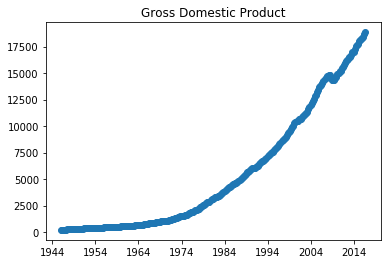

In [9]:
r = gdp.allObservations()
print('# items:', len(r))
displayListOfDicts(r[1000:1010])

gdp.plot()

In [10]:
"""
This seems true, if a little out of date:

Get all data for a Fred series id including first releases and all revisions. 
This returns a DataFrame with three columns: 'date', 'realtime_start', and 'value'. 
For instance, the US GDP for Q4 2013 was first released to be 17102.5 on 2014-01-30, 
and then revised to 17080.7 on 2014-02-28, 
and then revised to 17089.6 on 2014-03-27. 
You will therefore get three rows with the same 'date' (observation date) of 2013-10-01 but three
different 'realtime_start' of 2014-01-30, 2014-02-28, and 2014-03-27 
with corresponding 'value' of 17102.5, 17080.7 and 17089.6
"""

d = '2013-10-01'
t = [ i for i in r if i['date'] == d]
displayListOfDicts(t)

|date|realtime_end|realtime_start|value|
|-|-|-|-|
|2013-10-01|2014-02-27|2014-01-30|17102.5
|2013-10-01|2014-03-26|2014-02-28|17080.7
|2013-10-01|2014-07-29|2014-03-27|17089.6
|2013-10-01|2015-07-29|2014-07-30|17078.3
|2013-10-01|2016-07-28|2015-07-30|16957.6
|2013-10-01|9999-12-31|2016-07-29|16999.9

In [11]:
with db:
    fc = FredCategory('0')

while True:
    print()
    print(fc.name())
    if not fc.children():
        break
    displayListOfDicts(fc.childCategoryInfo())
    fc = fc.children()[0]


Categories


|id|name|parent_id|
|-|-|-|
|32991|Money, Banking, & Finance|0
|10|Population, Employment, & Labor Markets|0
|32992|National Accounts|0
|1|Production & Business Activity|0
|32455|Prices|0
|32263|International Data|0
|3008|U.S. Regional Data|0
|33060|Academic Data|0


Money, Banking, & Finance


|id|name|notes|parent_id|
|-|-|-|-|
|22|Interest Rates|None|32991
|15|Exchange Rates|None|32991
|24|Monetary Data|None|32991
|46|Financial Indicators|None|32991
|23|Banking|None|32991
|32360|Business Lending|None|32991
|32145|Foreign Exchange Intervention|In addition to the listed daily intervention series, intr...|32991


Interest Rates


|id|name|parent_id|
|-|-|-|
|33058|Automobile Loan Rates|22
|51|Bankers Acceptance Rate|22
|121|Certificates of Deposit|22
|120|Commercial Paper|22
|32348|Corporate Bonds|22
|33059|Credit Card Loan Rates|22
|32298|Eurodollar Deposits|22
|118|FRB Rates - discount, fed funds, primary credit|22
|33056|Interest Checking Accounts|22
|33446|Interest Rate Spreads|22
|32299|Interest Rate Swaps|22
|33003|LIBOR Rates|22
|32995|Long-Term Securities|22
|33055|Money Market Accounts|22
|114|Mortgage Rates|22
|33057|Personal Loan Rates|22
|117|Prime Bank Loan Rate|22
|33491|Saving Accounts|22
|116|Treasury Bills|22
|115|Treasury Constant Maturity|22
|82|Treasury Inflation-Indexed Securities|22


Automobile Loan Rates


In [12]:
if fc.seriesNames():
    for s in fc.series()[:5]:
        displayDict( s.info())
        print()
        print()

|key|value|
|-|-|
|frequency|Monthly
|frequency_short|M
|id|TERMAFCNCNSA
|last_updated|2012-06-26 12:01:23-05
|notes|For further information, please refer to the Board of Gov...
|observation_end|2011-01-01
|observation_start|1971-06-01
|popularity|50
|realtime_end|2017-05-31
|realtime_start|2017-05-31
|seasonal_adjustment|Not Seasonally Adjusted
|seasonal_adjustment_short|NSA
|title|New Car Average Finance Rate at Auto Finance Companies (D...
|units|Percent
|units_short|%

|key|value|
|-|-|
|frequency|Monthly
|frequency_short|M
|id|TERMCBAUTO48NS
|last_updated|2017-04-07 14:21:12-05
|notes|For further information, please refer to the Board of Gov...
|observation_end|2017-02-01
|observation_start|1972-02-01
|popularity|68
|realtime_end|2017-05-31
|realtime_start|2017-05-31
|seasonal_adjustment|Not Seasonally Adjusted
|seasonal_adjustment_short|NSA
|title|Finance Rate on Consumer Installment Loans at Commercial ...
|units|Percent
|units_short|%

In [13]:
with PrintMonitor(include='Web'):
    fc = FredCategory.get('15', db, create=True)

    while True:
        if not fc.activeEvents():
            fc.update()
        print()
        print(fc.name())
        if not fc.children():
            break
        displayListOfDicts(fc.childCategoryInfo())
        fc = fc.children()[0]
        
    
    info = []
    
    if fc.seriesNames():
        for s in fc.series():
            #print '# releases:', len(s.allReleases()), s.allReleases()[0]
            if not s.activeEvents():
                s.update()
            info.append(dict([ (k, s.info()[k]) for k in ['id', 'title'] ]) )
    displayListOfDicts(info)
    
displayDict(s.info())


Exchange Rates


|id|name|notes|parent_id|
|-|-|-|-|
|94|Daily Rates|Effective January 1, 2009, the Federal Reserve Board disc...|15
|95|Monthly Rates|None|15
|32219|Annual Rates|None|15
|105|Trade-Weighted Indexes|None|15
|158|By Country|None|15


Daily Rates


|id|title|
|-|-|
|DEXBZUS|Brazil / U.S. Foreign Exchange Rate
|DEXCAUS|Canada / U.S. Foreign Exchange Rate
|DEXCHUS|China / U.S. Foreign Exchange Rate
|DEXDNUS|Denmark / U.S. Foreign Exchange Rate
|DEXHKUS|Hong Kong / U.S. Foreign Exchange Rate
|DEXINUS|India / U.S. Foreign Exchange Rate
|DEXJPUS|Japan / U.S. Foreign Exchange Rate
|DEXKOUS|South Korea / U.S. Foreign Exchange Rate
|DEXMAUS|Malaysia / U.S. Foreign Exchange Rate
|DEXMXUS|Mexico / U.S. Foreign Exchange Rate
|DEXNOUS|Norway / U.S. Foreign Exchange Rate
|DEXSDUS|Sweden / U.S. Foreign Exchange Rate
|DEXSFUS|South Africa / U.S. Foreign Exchange Rate
|DEXSIUS|Singapore / U.S. Foreign Exchange Rate
|DEXSLUS|Sri Lanka / U.S. Foreign Exchange Rate
|DEXSZUS|Switzerland / U.S. Foreign Exchange Rate
|DEXTAUS|Taiwan / U.S. Foreign Exchange Rate
|DEXTHUS|Thailand / U.S. Foreign Exchange Rate
|DEXUSAL|U.S. / Australia Foreign Exchange Rate
|DEXUSEU|U.S. / Euro Foreign Exchange Rate
|DEXUSNZ|U.S. / New Zealand Foreign Exchange Rate
|DEXUSUK|U.S. / U.K. Foreign Exchange Rate
|DEXVZUS|Venezuela / U.S. Foreign Exchange Rate
|DTWEXB|Trade Weighted U.S. Dollar Index: Broad
|DTWEXM|Trade Weighted U.S. Dollar Index: Major Currencies
|DTWEXO|Trade Weighted U.S. Dollar Index: Other Important Trading...

|key|value|
|-|-|
|frequency|Daily
|frequency_short|D
|id|DTWEXO
|last_updated|2017-03-20 15:51:38-05
|notes|A weighted average of the foreign exchange value of the U...
|observation_end|2017-03-17
|observation_start|1995-01-04
|popularity|50
|realtime_end|2017-03-27
|realtime_start|2017-03-27
|seasonal_adjustment|Not Seasonally Adjusted
|seasonal_adjustment_short|NSA
|title|Trade Weighted U.S. Dollar Index: Other Important Trading...
|units|Index Jan 1997=100
|units_short|Index Jan 1997=100

Swiss Francs to One U.S. Dollar


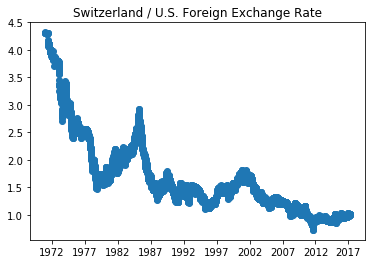

U.S. Dollars to One British Pound


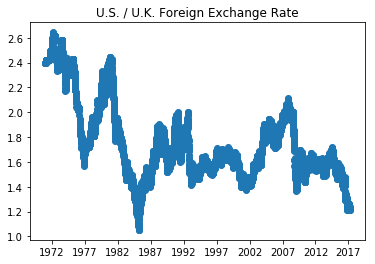

In [14]:
chf = FredSeries.get('DEXSZUS', db, create=True)
print(chf.info()['units'])
chf.plot()

gbp = FredSeries.get('DEXUSUK', db, create=True)
print(gbp.info()['units'])
gbp.plot()